In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import cuda_pytorch_layer
import torch

In [3]:
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
import os.path as osp
import os
import cv2
import numpy as np

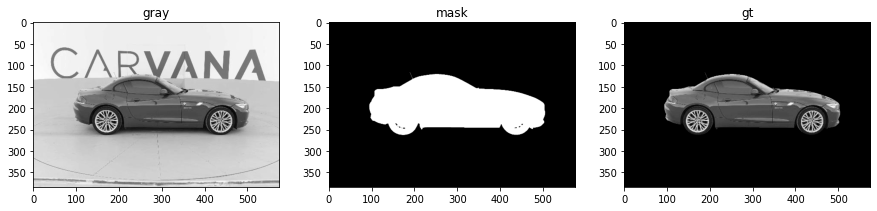

In [4]:
dp = './data'
rgb = io.imread(osp.join(dp, 'rgb.jpg'))
gray = rgb2gray(rgb)
mask = io.imread(osp.join(dp, 'mask.png')).astype(np.float32) / 255
gt = gray * mask

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(gray, cmap='gray')
axs[0].set_title('gray')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('mask')
axs[2].imshow(gt, cmap='gray')
axs[2].set_title('gt')
plt.show()

## we will optimize mask so that gray * mask = gt
mask is initialized with ones

gray - variable a

mask - variable b

In [5]:
device = torch.device('cuda:0')

a = torch.tensor(gray, dtype=torch.float32, device=device)
b = torch.ones_like(a)
gt = torch.tensor(gt, dtype=torch.float32, device=device)

b.requires_grad_()
params = [b]
opt = torch.optim.Adam(params, lr=1e-1)

loss_layer = torch.nn.L1Loss()
mult_layer = cuda_pytorch_layer.Mult()

steps = 100
losses_hist = []
for i in range(steps):
    product = mult_layer(a, b)
    
    loss = loss_layer(product, gt)
    
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()
    
    losses_hist.append(loss.item())

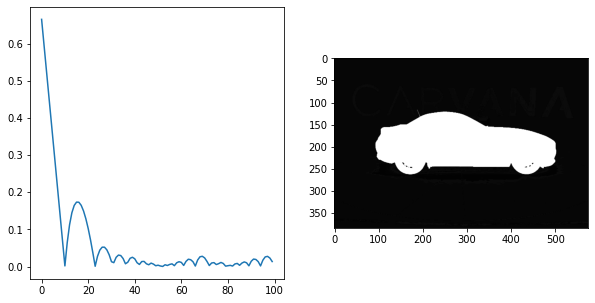

In [6]:
b_opt = b.detach().cpu().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(losses_hist)
axs[1].imshow(b_opt, cmap='gray')
plt.show()

io.imsave('./data/b_opt.png', (b_opt * 255).round().clip(0, 255).astype(np.uint8))